<a href="https://colab.research.google.com/github/btbcy/HYLee_ML_HW/blob/master/hw3_keras_tpu_experimental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
notebook = 'google'
# notebook = 'kaggle'

In [2]:
ls

sample_data/


# for kaggle kernel

In [3]:
if notebook == 'kaggle':
  !conda install -y gdown
  import gdown

# google drive

In [4]:
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip # 下載資料集

Downloading...
From: https://drive.google.com/uc?id=19CzXudqN58R3D-1G8KeFWk8UDQwlb8is
To: /content/food-11.zip
1.16GB [00:07, 164MB/s]


# unzip

In [5]:
!unzip -q food-11.zip

# import

In [6]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

Tensorflow version 2.3.0


# TPU

In [7]:
if notebook == 'kaggle':
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver()

if notebook == 'google':
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

INFO:tensorflow:Initializing the TPU system: grpc://10.124.238.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.124.238.210:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


# read data

In [8]:
def readfile(path, label):
    # label 是一個 boolean variable，代表需不需要回傳 y 值
    image_dir = sorted(os.listdir(path))
    # x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.uint8)
    x = np.zeros((len(image_dir), 128, 128, 3), dtype=np.float16)
    y = np.zeros((len(image_dir)), dtype=np.uint8)
#     y = np.zeros((len(image_dir)), dtype=np.float16)
    for i, file in enumerate(image_dir):
        img = cv2.imread(os.path.join(path, file))
        x[i, :, :] = cv2.resize(img,(128, 128)) * 1 / 255
        # do normalization on augmentation
        # x[i, :, :] = cv2.resize(img,(128, 128))
        if label:
          # keras.utils.to_categorical(int(file.split("_")[0]), num_classes=11)
          y[i] = int(file.split("_")[0])
    if label:
      return x, y
    else:
      return x

In [9]:
# 分別將 training set、validation set、testing set 用 readfile 函式讀進來
workspace_dir = './food-11'
print("Reading data")
train_x, train_y = readfile(os.path.join(workspace_dir, "training"), True)
print("Size of training data = {}".format(len(train_x)))
val_x, val_y = readfile(os.path.join(workspace_dir, "validation"), True)
print("Size of validation data = {}".format(len(val_x)))
test_x = readfile(os.path.join(workspace_dir, "testing"), False)
print("Size of Testing data = {}".format(len(test_x)))

Reading data
Size of training data = 9866
Size of validation data = 3430
Size of Testing data = 3347


## preprocessing

In [10]:
# Converts a class vector (integers) to binary class matrix.
train_y = keras.utils.to_categorical(train_y, num_classes=11)
val_y = keras.utils.to_categorical(val_y, num_classes=11)

index = np.arange(len(train_x))
np.random.shuffle(index)
train_x = train_x[index]
train_y = train_y[index]

# augmentation

In [11]:
# train_datagen = keras.preprocessing.image.ImageDataGenerator(
#     # featurewise_center=True,
#     # featurewise_std_normalization=True,
#     rotation_range=15,
#     # width_shift_range=0.2,
#     # height_shift_range=0.2,
#     # shear_range=0.2,
#     # zoom_range=0.2,
#     horizontal_flip=True,
# )
# # test_datagen = keras.preprocessing.image.ImageDataGenerator(
# #     rescale=1./255
# # )

# # compute quantities required for featurewise normalization
# # (std, mean, and principal components if ZCA whitening is applied)
# # train_datagen.fit(train_x)

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(128, 128, 3)),
  layers.experimental.preprocessing.RandomRotation(0.05),
  # layers.experimental.preprocessing.RandomHeight(0.1),
  # layers.experimental.preprocessing.RandomWidth(0.05),
  # layers.experimental.preprocessing.RandomZoom(0.1, 0.1)
  # layers.experimental.preprocessing.RandomZoom(0.1, input_shape=(128, 128, 3)),
])

# model

## dropout

In [ ]:
# dropout
def create_model():
  return tf.keras.Sequential([
    layers.BatchNormalization(input_shape=(128, 128, 3)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.2),

    layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.3),

    layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Dropout(0.4),

    layers.Flatten(),
    # layers.Dense(units=512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    layers.Dense(units=1024, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(units=512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(units=11, activation='softmax')
      
  ])

## batchnormalization

In [78]:
# batchnormalization
def create_model():
  return tf.keras.Sequential([
    # layers.BatchNormalization(input_shape=(128, 128, 3)),
    keras.Input(shape=(128, 128, 3)),
    layers.BatchNormalization(),
    # layers.Activation('relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', activation=None, name='Conv1_1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', activation=None, name='Conv1_2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=(2, 2), name='MaxPooling1'),
    layers.Dropout(0.2),

    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', activation=None, name='Conv2_1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', activation=None, name='Conv2_2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=(2, 2), name='MaxPooling2'),
    layers.Dropout(0.2),

    layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', activation=None, name='Conv3_1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    # layers.Dropout(0.3),
    layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', activation=None, name='Conv3_2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=(2, 2), name='MaxPooling3'),
    layers.Dropout(0.3),

    layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', activation=None, name='Conv4_1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    # layers.Dropout(0.4),
    layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', activation=None, name='Conv4_2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=(2, 2), name='MaxPooling4'),
    layers.Dropout(0.4),

    layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', activation=None, name='Conv5_1'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    # layers.Dropout(0.4),
    layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', kernel_initializer='he_normal', activation=None, name='Conv5_2'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPool2D(pool_size=(2, 2), name='MaxPooling5'),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(units=1024, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    layers.Dense(units=512, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.4),

    # layers.GlobalAveragePooling2D(name='avg_pool'),
    layers.Dense(units=11, activation='softmax', name='fc11')
      
  ])

In [76]:
def create_model():
  return tf.keras.applications.ResNet152V2(
    include_top=False,
    weights=None,
    input_tensor=None,
    input_shape=(128, 128, 3),
    pooling="avg",
    classes=11,
    classifier_activation="softmax",
  )

# dataset

In [56]:
batch_size = 256

In [57]:
val_dataset = (
#   tf.data.Dataset.from_tensor_slices((val_x,val_y))
  tf.data.Dataset.from_tensor_slices((tf.cast(val_x, tf.bfloat16), tf.cast(val_y, tf.bfloat16)))
  .batch(batch_size)
)
# val_dataset = val_dataset.batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices(tf.cast(test_x, tf.bfloat16))

In [58]:
train_dataset = (
#   tf.data.Dataset.from_tensor_slices((train_x, train_y))
  tf.data.Dataset.from_tensor_slices((tf.cast(train_x, tf.bfloat16), tf.cast(train_y, tf.bfloat16)))
  .shuffle(len(train_x))
  .batch(batch_size)
)

In [59]:
train_aug_dataset = (train_dataset.map(lambda x, y: (data_augmentation(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
  )
  .prefetch(tf.data.experimental.AUTOTUNE)
)

# train

In [79]:
if notebook == 'kaggle':
  strategy = tf.distribute.experimental.TPUStrategy(resolver)

if notebook == 'google':
  strategy = tf.distribute.TPUStrategy(resolver)
# strategy = tf.distribute.MirroredStrategy(resolver)
with strategy.scope():
  model = create_model()
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    # optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    loss='categorical_crossentropy',
#     loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
  )

model.summary()

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_143 (Bat (None, 128, 128, 3)       12        
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_144 (Bat (None, 128, 128, 64)      256       
_________________________________________________________________
activation_130 (Activation)  (None, 128, 128, 64)      0         
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_145 (Bat (None, 128, 128, 64)      256       
_________________________________________________________________
activation_131 (Activation)  (None, 128, 128, 64)    

In [64]:
epochs = 5

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=5)
# history = model.fit(train_aug_dataset, batch_size=batch_size, epochs=epochs, validation_data=val_dataset, callbacks=[reduce_lr])
history = model.fit(train_aug_dataset, batch_size=batch_size, epochs=epochs, validation_data=val_dataset)
# history = model.fit(train_aug_dataset, batch_size=batch_size, epochs=epochs)

Epoch 1/5
 2/39 [>.............................] - ETA: 12s - loss: 0.1971 - accuracy: 0.9453WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0060s vs `on_train_batch_end` time: 0.1458s). Check your callbacks.


39/39 [==============================] - ETA: 0s - loss: 0.2326 - accuracy: 0.9189WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0031s vs `on_test_batch_end` time: 0.0313s). Check your callbacks.


39/39 [==============================] - 7s 188ms/step - loss: 0.2326 - accuracy: 0.9189 - val_loss: 1.3605 - val_accuracy: 0.6962
Epoch 2/5
39/39 [==============================] - 7s 189ms/step - loss: 0.2154 - accuracy: 0.9231 - val_loss: 1.2582 - val_accuracy: 0.7303
Epoch 3/5
39/39 [==============================] - 7s 184ms/step - loss: 0.1980 - accuracy: 0.9317 - val_loss: 1.1466 - val_accuracy: 0.7300
Epoch 4/5
39/39 [==============================] - 7s 183ms/step - loss: 0.1950 - accuracy: 0.9347 - val_loss: 1.0239 - val_accuracy: 0.7566
Epoch 5/5
39/39 [==============================] - 7s 182ms/step - loss: 0.1807 - accuracy: 0.9356 - val_loss: 1.1811 - val_accuracy: 0.7280


# evaluate

 1/39 [..............................] - ETA: 12s - loss: 0.2671 - accuracy: 0.8906WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0035s vs `on_test_batch_end` time: 0.0357s). Check your callbacks.


 1/14 [=>............................] - ETA: 0s - loss: 2.2624 - accuracy: 0.4297WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0036s vs `on_test_batch_end` time: 0.0325s). Check your callbacks.


14/14 [==============================] - 1s 42ms/step - loss: 1.1811 - accuracy: 0.7280
Train Acc: 0.9210419058799744
Test Acc: 0.7279883027076721
Max Test Acc: 0.7565597295761108


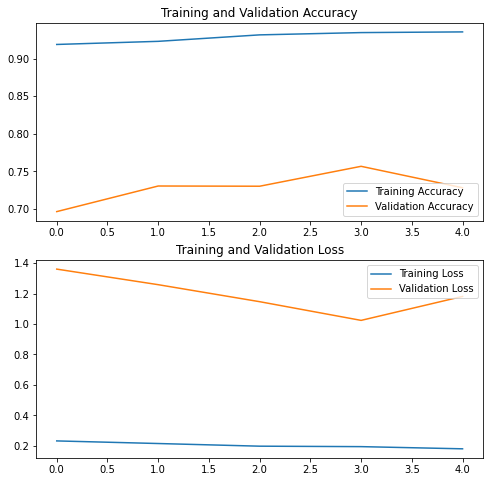

In [65]:
train_result = model.evaluate(train_dataset)
val_result = model.evaluate(val_dataset)
print('Train Acc:', train_result[1])
print('Test Acc:', val_result[1])
print('Max Test Acc:', max(history.history['val_accuracy']))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# prediction

In [66]:
train_val_x = np.concatenate((train_x, val_x), axis=0)
train_val_y = np.concatenate((train_y, val_y), axis=0)

In [67]:
train_val_dataset = (
#   train_dataset.concatenate(val_dataset)
  tf.data.Dataset.from_tensor_slices((tf.cast(train_val_x, tf.bfloat16), (tf.cast(train_val_y, tf.bfloat16))))
  .shuffle(len(train_val_x))
  .batch(batch_size)
)

In [68]:
train_val_aug_dataset = (train_val_dataset.map(lambda x, y: (data_augmentation(x), y),
    num_parallel_calls=tf.data.experimental.AUTOTUNE
  )
  .prefetch(tf.data.experimental.AUTOTUNE)
)

In [69]:
strategy2 = tf.distribute.experimental.TPUStrategy(resolver)
with strategy2.scope():
  model_best = create_model()
  model_best.compile(
    optimizer=keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

model_best.summary()

INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_130 (Bat (None, 128, 128, 3)       12        
_________________________________________________________________
Conv1_1 (Conv2D)             (None, 128, 128, 64)      1792      
_________________________________________________________________
batch_normalization_131 (Bat (None, 128, 128, 64)      256       
_________________________________________________________________
activation_118 (Activation)  (None, 128, 128, 64)      0         
_________________________________________________________________
Conv1_2 (Conv2D)             (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_132 (Bat (None, 128, 128, 64)      256       
_________________________________________________________________
activation_119 (Activation)  (None, 128, 128, 64)    

In [72]:
epochs = 5
history_best = model_best.fit(train_val_aug_dataset, batch_size=batch_size, epochs=epochs, validation_data=val_dataset)

Epoch 1/5
 2/52 [>.............................] - ETA: 16s - loss: 0.1042 - accuracy: 0.9668WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0063s vs `on_train_batch_end` time: 0.1411s). Check your callbacks.


52/52 [==============================] - ETA: 0s - loss: 0.1316 - accuracy: 0.9540WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0034s vs `on_test_batch_end` time: 0.0298s). Check your callbacks.


52/52 [==============================] - 9s 175ms/step - loss: 0.1316 - accuracy: 0.9540 - val_loss: 0.1440 - val_accuracy: 0.9499
Epoch 2/5
52/52 [==============================] - 9s 173ms/step - loss: 0.1201 - accuracy: 0.9593 - val_loss: 0.1605 - val_accuracy: 0.9464
Epoch 3/5
52/52 [==============================] - 9s 176ms/step - loss: 0.1074 - accuracy: 0.9633 - val_loss: 0.1073 - val_accuracy: 0.9618
Epoch 4/5
52/52 [==============================] - 9s 175ms/step - loss: 0.1172 - accuracy: 0.9605 - val_loss: 0.0854 - val_accuracy: 0.9706
Epoch 5/5
52/52 [==============================] - 9s 178ms/step - loss: 0.1157 - accuracy: 0.9592 - val_loss: 0.1079 - val_accuracy: 0.9653


 1/52 [..............................] - ETA: 21s - loss: 0.1371 - accuracy: 0.9570WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0032s vs `on_test_batch_end` time: 0.0355s). Check your callbacks.


52/52 [==============================] - 2s 47ms/step - loss: 0.1030 - accuracy: 0.9656
Train Acc: 0.9656288027763367


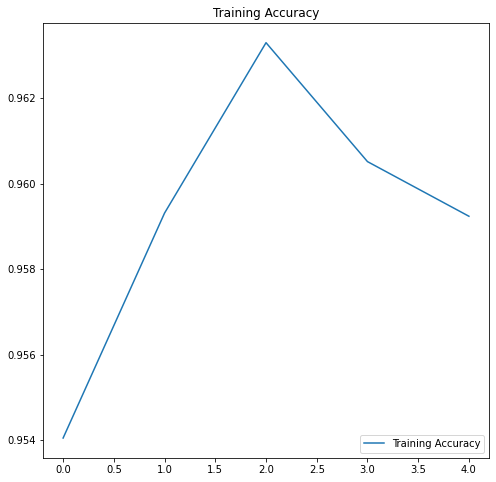

In [73]:
train_result_best = model_best.evaluate(train_val_dataset)
print('Train Acc:', train_result_best[1])

acc = history_best.history['accuracy']

loss=history_best.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))

plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.show()

In [75]:
prediction = np.argmax(model_best.predict(test_x), axis=1)
# with open("gdrive/My Drive/Colab Notebooks/Hung-yi Lee HW/HW3_CNN/predict_0902_1551.csv", 'w') as f:
with open("predict_0903_1436.csv", 'w') as f:
    f.write('Id,Category\n')
    for i, y in  enumerate(prediction):
        f.write('{},{}\n'.format(i, y))